<h1>Skillcraft Dataset Analysis<h1>

### Authors:
David Nogales Perez

Alex Ochoa

Uncomment command to install the necessary libraries.

In [1]:
#!pip install -r requirements.txt

Import necesary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from time import time

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR,LinearSVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler,KBinsDiscretizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import r2_score,mean_absolute_error

from sklearn.decomposition import PCA



Download necesary data or read existing one.

In [3]:
try:
  data_df = pd.read_csv('SkillCraft1_Dataset.csv')    
except:
  print('Data not found, proceeding to download necessary files...')
  data_url ='http://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv'
  data_df = pd.read_csv(data_url)

data_df = data_df.drop(['GameID'],axis=1)

Data not found, proceeding to download necessary files...


# Data Exploration 

### Balancing Data and Dealing with Null values

Observing the histogram plot of the target variable, one can see that the dataset is heavily unbalanced mainly due to the extreme categories. Given that we can't obtain more data we should study if we can afford to drop these categories, or try another methods such as merging them given that some categories in the Starcraft Ladder aren't too different in terms of skill.

Text(0.5, 1.0, 'League Distribution')

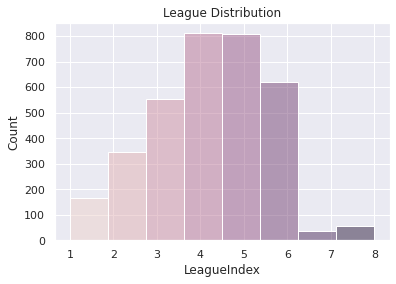

In [29]:
sns.histplot(data_df,x="LeagueIndex", hue="LeagueIndex", legend=False,bins=8).set_title('League Distribution')

Looking at the information of the dataframe, there are some variables which are numeric but appear as object and also there seemingly aren't any null values

In [30]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LeagueIndex           3395 non-null   int64  
 1   Age                   3395 non-null   object 
 2   HoursPerWeek          3395 non-null   object 
 3   TotalHours            3395 non-null   object 
 4   APM                   3395 non-null   float64
 5   SelectByHotkeys       3395 non-null   float64
 6   AssignToHotkeys       3395 non-null   float64
 7   UniqueHotkeys         3395 non-null   int64  
 8   MinimapAttacks        3395 non-null   float64
 9   MinimapRightClicks    3395 non-null   float64
 10  NumberOfPACs          3395 non-null   float64
 11  GapBetweenPACs        3395 non-null   float64
 12  ActionLatency         3395 non-null   float64
 13  ActionsInPAC          3395 non-null   float64
 14  TotalMapExplored      3395 non-null   int64  
 15  WorkersMade          

After converting the variables to numeric we found that there are indeed null values in the dataset

In [31]:
num_data_df = data_df.copy(deep=True)
num_data_df.Age = pd.to_numeric(num_data_df.Age,errors='coerce')
num_data_df.HoursPerWeek = pd.to_numeric(num_data_df.HoursPerWeek,errors='coerce')
num_data_df.TotalHours = pd.to_numeric(num_data_df.TotalHours,errors='coerce')
num_data_df.isna().sum()

LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

Separate 'NA' values in order to visualize the data

In [32]:
data_non_na_df = num_data_df.dropna(axis=0,how='any')
na_data_df = num_data_df[num_data_df.isna().any(axis=1)]
print(data_non_na_df.isna().sum())

LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64


4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64
8    55
5     2
Name: LeagueIndex, dtype: int64


Text(0.5, 1.0, 'Missing Data By League Index')

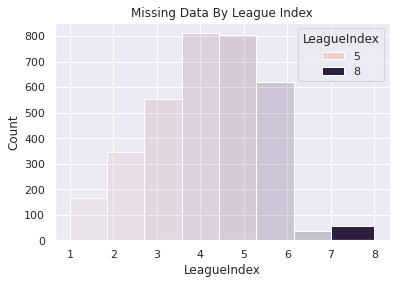

In [33]:
print(data_non_na_df['LeagueIndex'].value_counts())
print(na_data_df['LeagueIndex'].value_counts())
ax = sns.histplot(data_non_na_df,x="LeagueIndex",hue="LeagueIndex",alpha=0.2,bins=7)
sns.histplot(na_data_df,x="LeagueIndex", multiple="stack",ax=ax,alpha=1,hue="LeagueIndex",bins=3).set_title('Missing Data By League Index')

Looking at the graph we can see that most of our missing data is in  located in the 'Professional' category (8) and only 2 rows in the 5th category have missing data.

A solution to this would be imputing all the missing data in the corresponding categories instead of dropping them since we could be dropping valuable data. But given that our data sample of these categories are to low there is no way to know if the values we would be imputing will be correct, so we will drop them.

To solve the problem regarding the unbalanced data we will merge categories 1,2 and 6,7 given that according to the global statistics of ranks of the population of active players in the game through [different seasons ](https://www.rankedftw.com/stats/leagues/1v1/#v=2&r=-2&sx=a), these categories have a smaller number of players in general so by merging them we will be able to better predict the remaining ranks.

In [34]:
ranks = {
    1:1,
    2:1,
    3:2,
    4:3,
    5:4,
    6:5,
    7:5
}
data_merged_ranks_df = data_non_na_df.copy(deep=True)
data_merged_ranks_df["LeagueIndex"] = data_non_na_df["LeagueIndex"].replace(ranks)

4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64
3    811
4    804
5    656
2    553
1    514
Name: LeagueIndex, dtype: int64


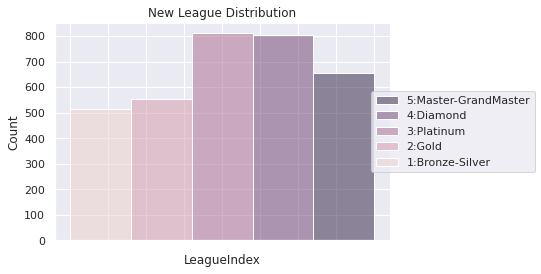

In [35]:
print(data_non_na_df['LeagueIndex'].value_counts())
print(data_merged_ranks_df['LeagueIndex'].value_counts())
g = sns.histplot(data_merged_ranks_df,x="LeagueIndex", hue="LeagueIndex",bins=5)
g.set_title('New League Distribution')
g.set(xticklabels=[])
new_ranks = ["1:Bronze-Silver", "2:Gold", "3:Platinum", "4:Diamond", "5:Master-GrandMaster"]
new_ranks.reverse()
g.legend(new_ranks, loc='center right', bbox_to_anchor=(1.45, 0.5), ncol=1)

### Detecting Outliers

Looking at the description of the variables one can rapidly tell the presence of outliers. For example in the variable `TotalHours` we have that someone played the game a million hours which is roughly 114 years. Similarly in `HoursPerWeek` the maximum of hours played in a week is 168 hours which would mean a week of playing the game without rest. 

In [36]:
data_merged_ranks_df.describe()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,3.160276,21.650389,15.909527,960.421809,114.575763,0.004023,0.000364,4.316357,0.000094,0.000380,0.003433,40.713819,64.209584,5.266955,22.116836,0.001031,6.541043,0.000060,0.000142
std,1.335445,4.206357,11.964495,17318.133922,48.111912,0.004726,0.000210,2.333322,0.000159,0.000359,0.000966,17.057191,19.037394,1.500605,7.440875,0.000520,1.859049,0.000112,0.000266
min,1.000000,16.000000,0.000000,3.000000,22.059600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000077,2.000000,0.000000,0.000000
25%,2.000000,19.000000,8.000000,300.000000,79.231500,0.001245,0.000202,3.000000,0.000000,0.000139,0.002743,29.326600,50.886425,4.261525,17.000000,0.000682,5.000000,0.000000,0.000000
50%,3.000000,21.000000,12.000000,500.000000,107.070300,0.002445,0.000349,4.000000,0.000039,0.000278,0.003376,37.058900,61.296100,5.087050,22.000000,0.000904,6.000000,0.000000,0.000020
75%,4.000000,24.000000,20.000000,800.000000,140.156100,0.004945,0.000493,6.000000,0.000113,0.000508,0.004003,48.510425,74.032525,6.027350,27.000000,0.001258,8.000000,0.000087,0.000182
max,5.000000,44.000000,168.000000,1000000.000000,389.831400,0.043088,0.001648,10.000000,0.003019,0.003688,0.007971,237.142900,176.372100,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


Analyzing the violin plots of the dataset we can clearly observe the presence of outliers in different variables.

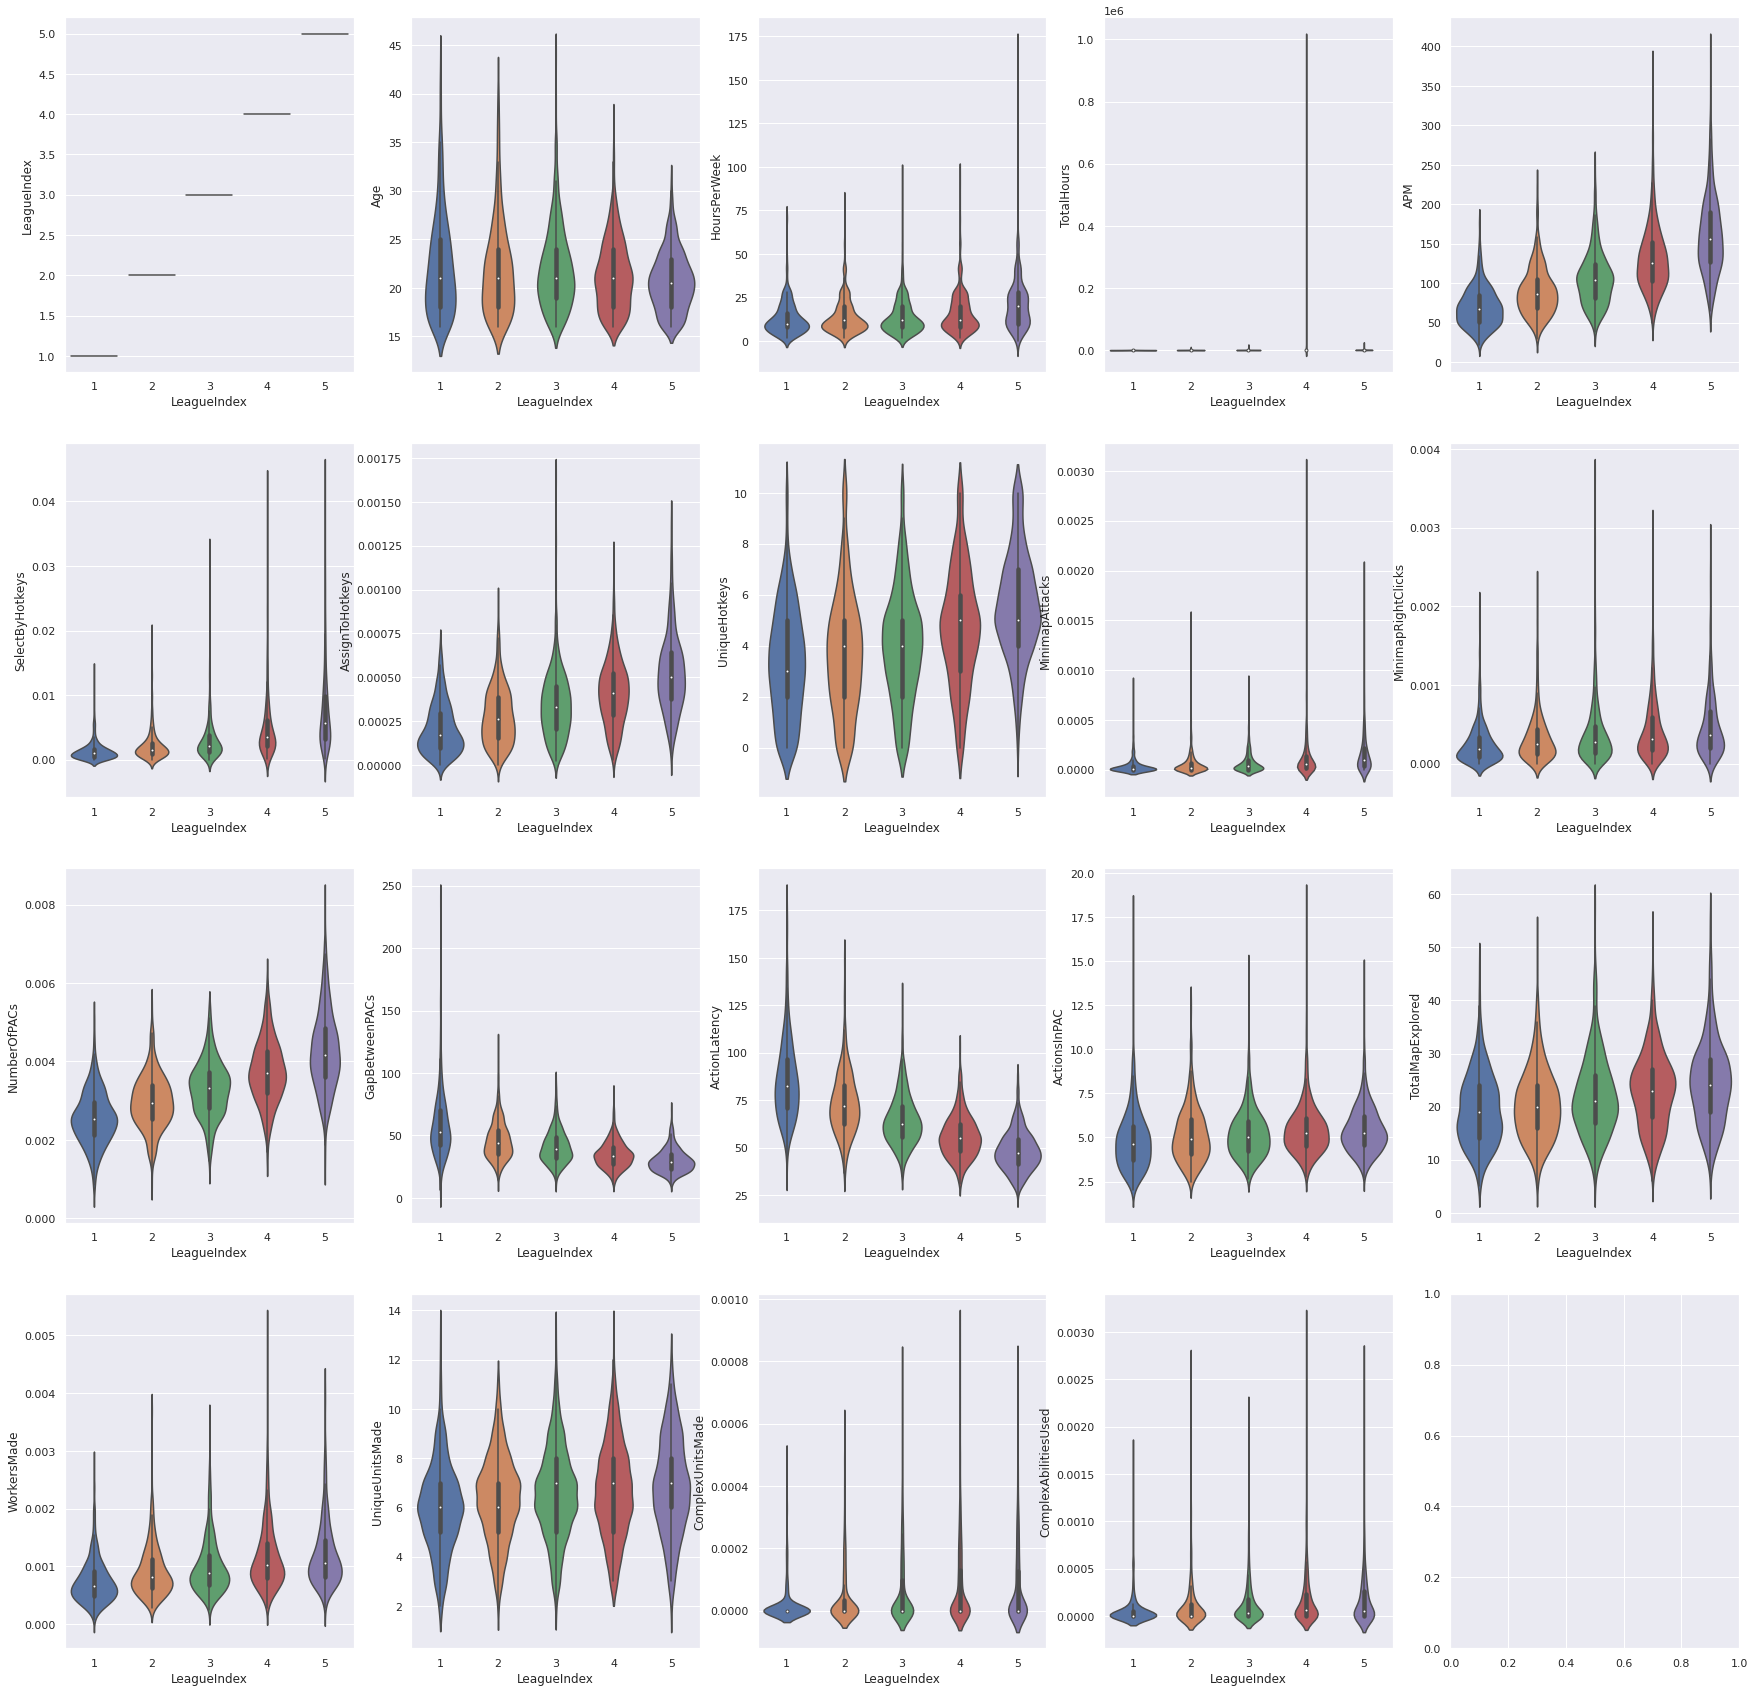

In [37]:
def violinplot_from_df(df):
    num_cols = np.shape(df.columns)[0]
    fig, axs = plt.subplots(4,5,figsize=(30,30))
    for num in np.arange(0,num_cols):
        sns.violinplot(x="LeagueIndex", y=df.columns[num], data=df,ax=axs.flat[num])

violinplot_from_df(data_merged_ranks_df)

### Filter Extreme values

Since most of the extreme values appear to be in the upper points of the violin plots we will erase values greater to the 99 percentile.

Although outliers are still present in our data we can't erase or modify them since those data points may pertain to players who are close to climb the classification ladder.

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
count,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000,3209.000000
mean,3.155189,21.692739,14.951075,596.615457,114.194964,0.003970,0.000363,4.312247,0.000093,0.000381,0.003431,40.129980,63.996335,5.267483,22.065441,0.001035,6.539732,0.000059,0.000139
std,1.323431,4.186170,9.521752,422.780938,47.214595,0.004637,0.000208,2.332087,0.000158,0.000360,0.000944,15.006833,18.102238,1.484720,7.377940,0.000521,1.852678,0.000111,0.000258
min,1.000000,16.000000,0.000000,3.000000,24.904200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000679,6.666700,24.632600,2.038900,5.000000,0.000165,2.000000,0.000000,0.000000
25%,2.000000,19.000000,8.000000,300.000000,79.401600,0.001250,0.000204,3.000000,0.000000,0.000140,0.002751,29.407000,51.190000,4.263900,17.000000,0.000686,5.000000,0.000000,0.000000
50%,3.000000,21.000000,12.000000,500.000000,106.877400,0.002425,0.000348,4.000000,0.000039,0.000279,0.003374,37.111900,61.356700,5.090700,22.000000,0.000905,6.000000,0.000000,0.000020
75%,4.000000,24.000000,20.000000,800.000000,139.395000,0.004842,0.000491,6.000000,0.000111,0.000510,0.003989,48.290600,73.886600,6.028200,27.000000,0.001258,8.000000,0.000085,0.000178
max,5.000000,44.000000,50.000000,2400.000000,389.831400,0.042258,0.001648,10.000000,0.003019,0.003688,0.007971,96.482500,165.568600,18.558100,58.000000,0.005149,13.000000,0.000902,0.003084


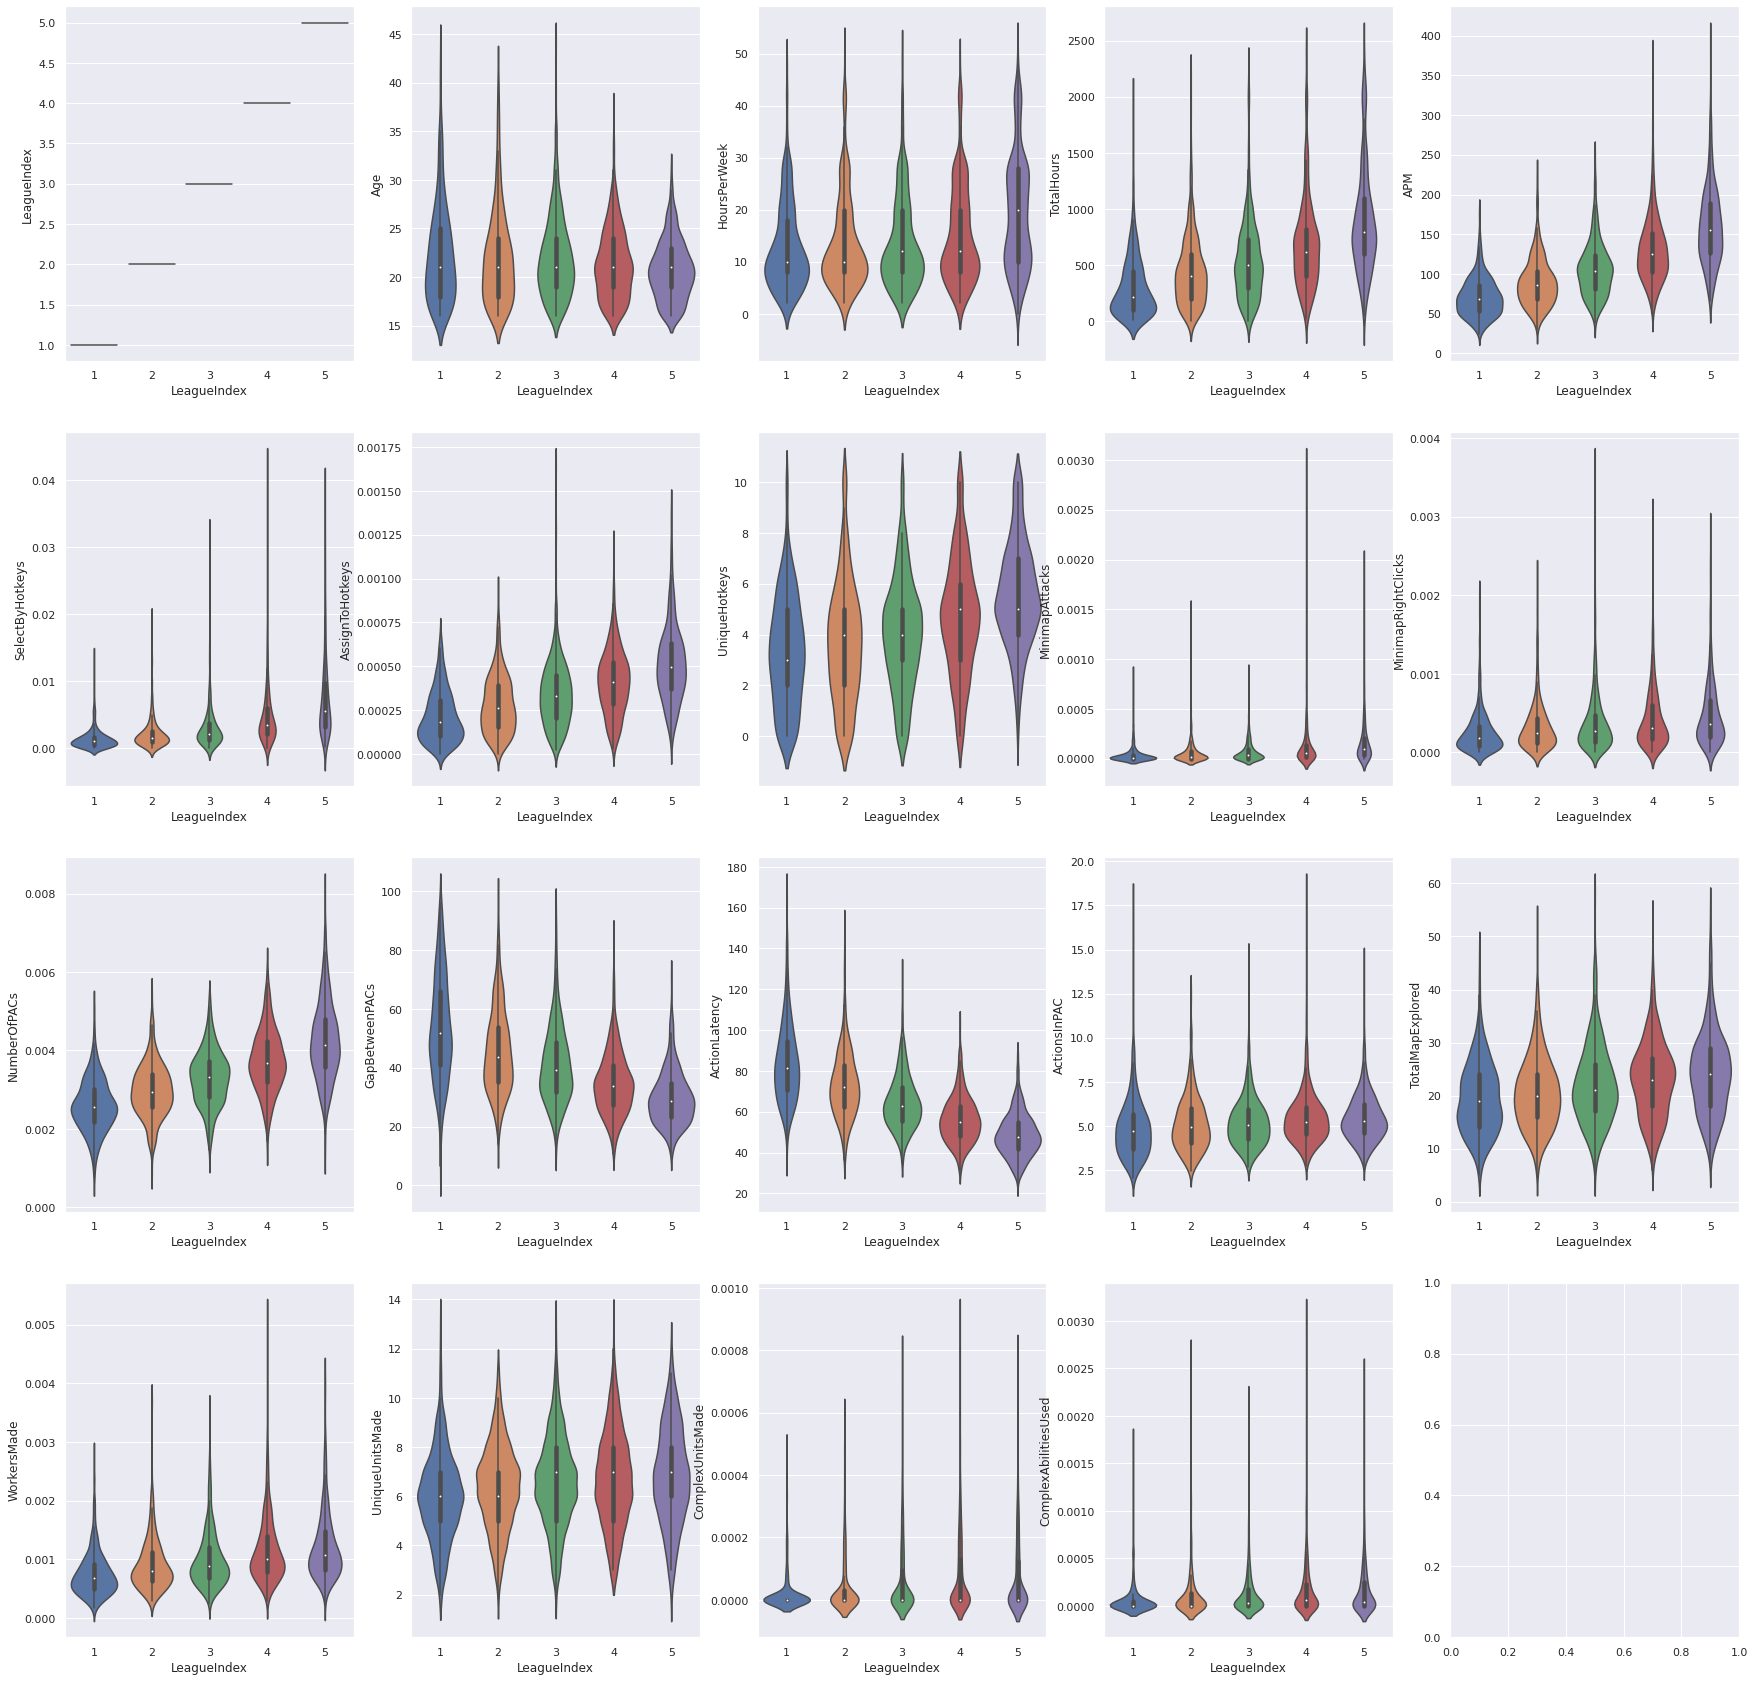

In [38]:
df_filtered = data_merged_ranks_df.copy(deep=True)
columns_with_extreme_values = ["HoursPerWeek","TotalHours","GapBetweenPACs"]
for col in columns_with_extreme_values:
    if col!="LeagueIndex":
        q_hi  = df_filtered[col].quantile(0.99)
        df_filtered = df_filtered[(df_filtered[col] < q_hi)]
violinplot_from_df(df_filtered)    
df_filtered.describe()


In [39]:
print('Erased Rows by category after filtering:\n',data_merged_ranks_df['LeagueIndex'].value_counts()-df_filtered['LeagueIndex'].value_counts())
print('Current rows by category after filtering:\n',df_filtered['LeagueIndex'].value_counts())
df_filtered = df_filtered.reset_index(drop=True)


Erased Rows by category after filtering:
 3    13
4    30
5    42
2    11
1    33
Name: LeagueIndex, dtype: int64
Current rows by category after filtering:
 3    798
4    774
5    614
2    542
1    481
Name: LeagueIndex, dtype: int64


## Discretizing Age

Since our data does not have a discrete variable we are tasked to create one. To do that we chose Age which will be automatically discretized by the `KBinsDiscretizer`, which will create 3 new categories of same size.

In [40]:
df_filtered2 = df_filtered.copy(deep=True)
est = KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='uniform')
age_data_discretized = est.fit_transform(df_filtered2["Age"].to_numpy().reshape(-1, 1))
df_filtered2 = pd.DataFrame(data=age_data_discretized,columns=["age_0","age_1","age_2"])
df_filtered2 = pd.concat([df_filtered.drop("Age",axis=1), df_filtered2], axis=1)
df_filtered = df_filtered2

## Feature Selection

We will perform Feature Selection instead of Feature Extraction avoiding the change of variables' space performed by applying PCA.

<h3>Correlation Matrix<h3>

Observing the Correlation Heatmap one can tell that the target variable has a relatively high correlation with `APM` and `NumberOfPACs`, in contrast, we have that is inversely correlated with `ActionLatency` and `GapBetweenPACs`

Text(0.5, 1.0, 'Correlation Heatmap Skillcraft Dataset')

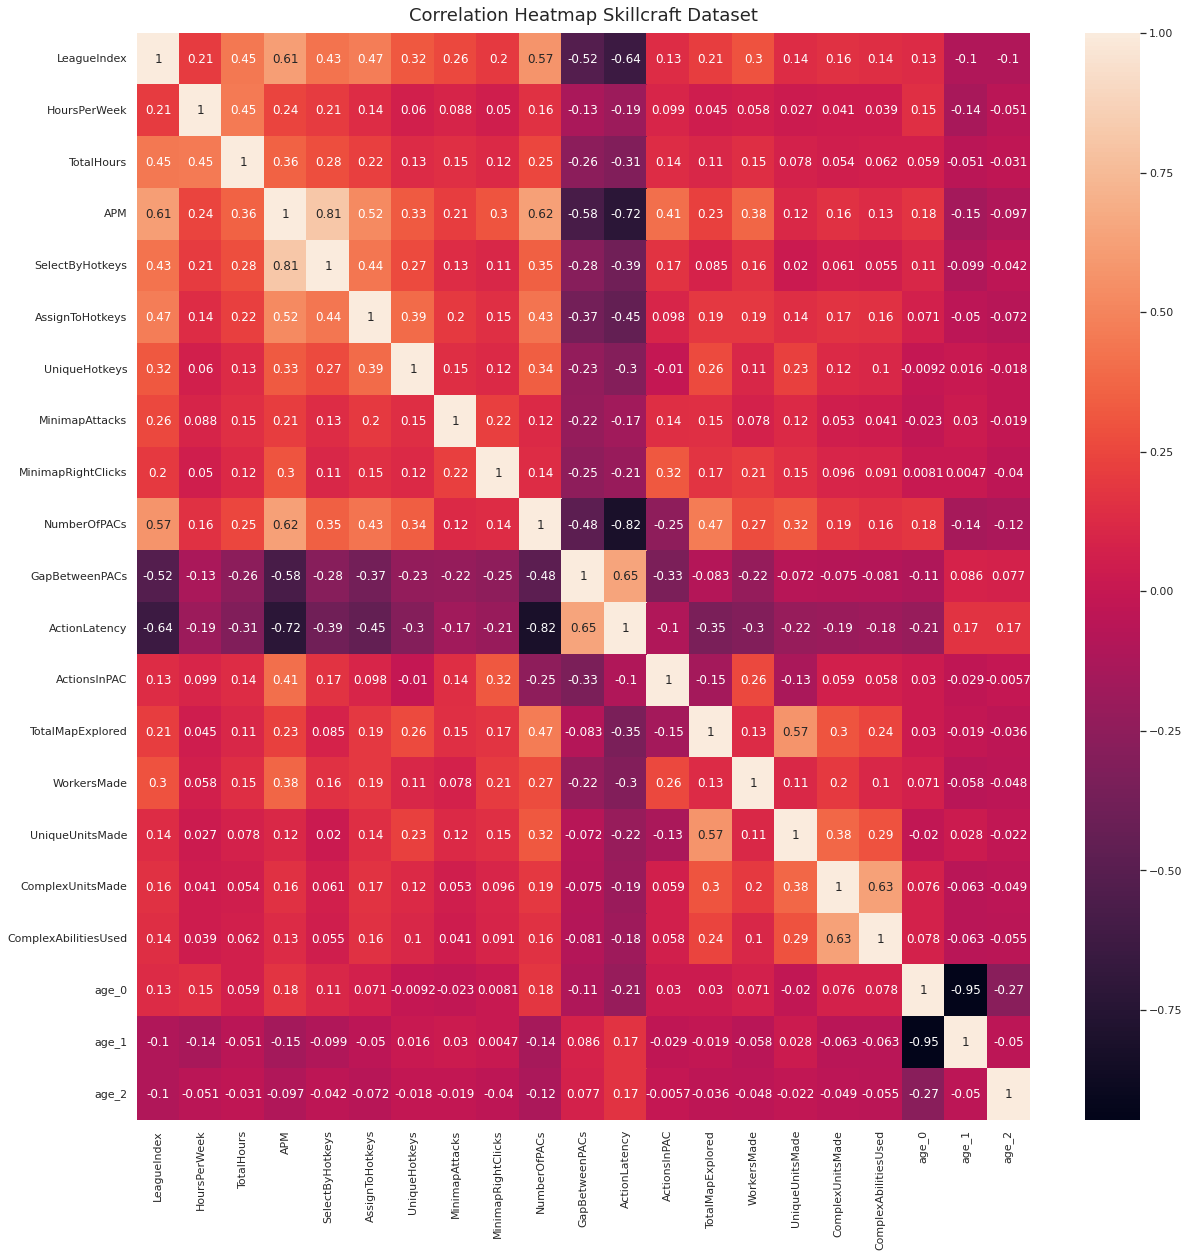

In [41]:
plt.figure(figsize=(20, 20))
ax=sns.heatmap(df_filtered.corr(), annot=True)
ax.set_title('Correlation Heatmap Skillcraft Dataset', fontdict={'fontsize':18}, pad=12)

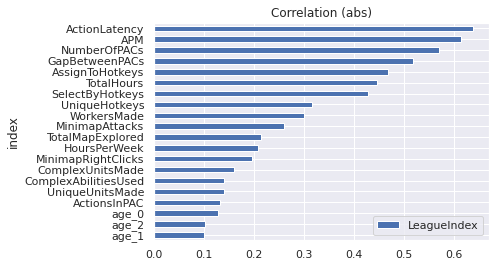

In [42]:
df_corr = df_filtered.corr().abs().sort_values('LeagueIndex',ascending=True).drop('LeagueIndex',axis=0).reset_index()
df_corr.plot(kind='barh',x='index',y='LeagueIndex',title="Correlation (abs)");

Looking at the absolute value of the correlations we have that at least 9 features have a relatively big impact on the target variable, meanwhile the rest does not seem to be that important.

### Feature Importance

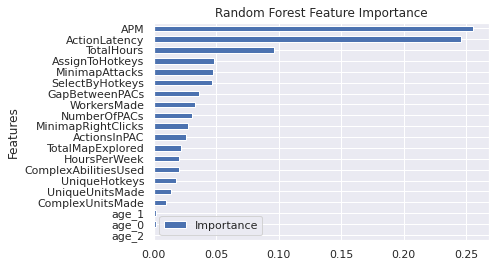

In [43]:
rf_reg = RandomForestRegressor()
y = df_filtered.LeagueIndex
X = df_filtered.drop(['LeagueIndex'],axis=1)
rf_reg.fit(X,y)
features = X.columns
importance = pd.DataFrame()
importance['Features'] = X.columns
importance['Importance'] = rf_reg.feature_importances_
importance2 = importance.copy(deep=True)
importance = importance.sort_values(by=['Importance'],ascending=True)
labels = importance['Features']
values = importance['Importance']
importance.plot(kind='barh',x='Features',y='Importance',title="Random Forest Feature Importance");

According to the Random Forest Regressor we can explain aproximately $60\%$ of the variance using only `APM`, `ActionLatency` and `TotalHours` variables. 

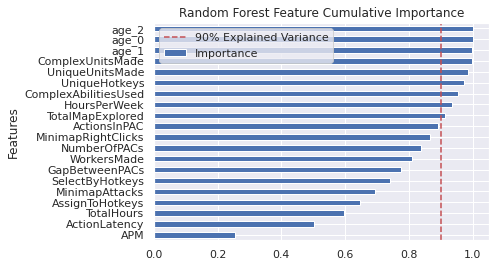

In [44]:
importance2 = importance2.sort_values(by=['Importance'],ascending=False)
importance2['Importance'] = importance2['Importance'].cumsum()
ax = importance2.plot(kind='barh',x='Features',y='Importance',title="Random Forest Feature Cumulative Importance");
ax.axvline(x=0.90, color='r', linestyle='--', label = '90% Explained Variance')
ax.legend()

Looking at the cumulative sum of the importances we can see that we can explain $90\%$ of the variance using 12 features instead of 20.

In [45]:
corr_important_features = set(df_filtered.corr().abs().sort_values('LeagueIndex',ascending=False).drop('LeagueIndex',axis=0).index[0:10].tolist())
rf_important_features = set(importance.sort_values(by=['Importance'],ascending=False)["Features"][0:10].tolist())
features_to_drop = list(corr_important_features.intersection(rf_important_features))
features_to_drop.append('LeagueIndex')

df_important_features = df_filtered[df_filtered.columns.intersection(features_to_drop)]
df_important_features

,LeagueIndex,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,MinimapAttacks,NumberOfPACs,GapBetweenPACs,ActionLatency,WorkersMade
0,3,200.0,69.9612,0.001101,0.000336,0.000294,0.002926,44.6475,75.3548,0.000745
1,2,400.0,107.6016,0.001034,0.000213,0.000053,0.003783,29.2203,53.7352,0.000426
2,2,500.0,122.8908,0.001136,0.000327,0.000000,0.002368,22.6885,62.0813,0.001174
3,1,70.0,44.4570,0.000978,0.000255,0.000000,0.002425,76.4405,98.7719,0.000372
4,1,240.0,46.9962,0.000820,0.000169,0.000000,0.001988,94.0227,90.5311,0.000573
...,...,...,...,...,...,...,...,...,...,...
3204,3,1500.0,96.6198,0.001471,0.000371,0.000000,0.002614,47.2967,82.3825,0.000514
3205,3,400.0,158.1390,0.013829,0.000504,0.000217,0.003583,36.3990,66.2718,0.001035
3206,3,100.0,121.6992,0.002956,0.000241,0.000055,0.003690,35.5833,57.9585,0.002014
3207,2,400.0,134.2848,0.005424,0.000182,0.000000,0.003205,18.2927,62.4615,0.000934


By intersecting the 10 most important features found with the correlation matrix and feature importances of the Random Forest we end up with 9 features instead of 20, which is a reduction of more than half of the variables.

## Training Models

Our target variable is Ordinal so the models chosen are regression models in order to avoid losing the inherent relationship between the ranks of the players and also lose prediction power.

First we split the training and test data. Being $70\%$ for training and $30\%$ for testing. 

In [46]:
def split_and_scale_data(X,y,train_size=0.7):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=1)
    print(np.shape(y_train),np.shape(y_test))
    fig, axs = plt.subplots(1)
    g = sns.histplot(y_train, color="g",bins=5,ax= axs)
    sns.histplot(y_test,color="m",bins=5,ax=g)
    axs.legend([f"Train {(train_size*100):.2f}%",f"Test {(1-train_size)*100:.2f}%"])

    
    scale = StandardScaler()
    X_train_scaled = scale.fit_transform(X_train)
    X_test_scaled = scale.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

def train_model(model, hyperparameters, x_tr, y_tr, x_te, y_te, results,model_name="",perform_pca=False,pca_components=0.90):
  if (perform_pca):
    print("reducing dimensions...\n")
    pca = PCA(n_components=pca_components)
    pca.fit(x_tr)
    x_tr = pd.DataFrame(pca.transform(x_tr), columns=["PC" + str(i + 1) for i in range(pca.n_components_)])
    x_te = pd.DataFrame(pca.transform(x_te), columns=["PC" + str(i + 1) for i in range(pca.n_components_)])
    print("     number of components:",pca.n_components_)
    print("     Explained variance ratio",pca.explained_variance_ratio_)
    print("     Explained variance ratio sum",np.cumsum(pca.explained_variance_ratio_))
  # Tuning parameters using RandomizedSearchCV
  regressor = model()
  if model_name=="":
    model_name = model.__name__
  rnd_search = RandomizedSearchCV(regressor, hyperparameters, cv=5, n_jobs=-1,scoring='neg_mean_absolute_error' ,random_state=42)
  params = (rnd_search.fit(x_tr, y_tr))
  print(f"Best hyperparameters for {model_name}:\n",params.best_params_)
  # Train model with best parameters using CV
  regressor = model(**params.best_params_).fit(x_tr, y_tr)
  scores = cross_val_score(regressor, x_tr, y_tr, cv=5,scoring='neg_mean_absolute_error')
  print(f"Using best parameters, CV MAE score: {scores.mean():0.2f}")
  print('-'*50)
  
  # Generate prediction
  ini_time = time()
  for i in range(10):
    y_pr = regressor.predict(x_te)
  pred_time = time()-ini_time

  test_score_r2 = r2_score(y_te, y_pr)
  test_score_mae = mean_absolute_error(y_te, y_pr)
  print(f"Test score R2: {test_score_r2:0.2f}")
  print(f"Test score MAE: {test_score_mae:0.2f}")

  # Store results
  results.at['Test score R2', model_name] = test_score_r2
  results.at['Test score MAE', model_name] = test_score_mae
  results.at['Train score MAE', model_name] = scores.mean()
  results.at['Prediction Time', model_name] = pred_time
  # Plot prediction vs real values
  predict_df = pd.DataFrame({'Predictions': y_pr, 'Real': y_test})
  predict_df = predict_df.reset_index()
  ax = predict_df.reset_index().plot(kind='scatter',x='index',y="Real",figsize=(20,15),title=f"Prediction vs Real value {model_name}",alpha=0.3,c="DarkBlue") 
  predict_df.plot(kind='scatter',x='index',y="Predictions",alpha=0.9,ax=ax,c="Real",colormap='viridis') 
  return regressor, results

(2246,) (963,)


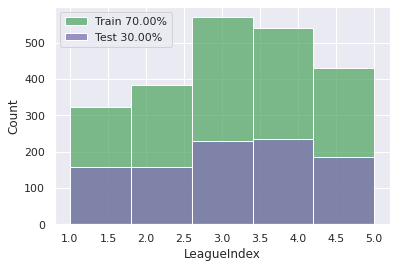

In [47]:
y = df_important_features.LeagueIndex
X = df_important_features.drop(['LeagueIndex'],axis=1)
train_size = 0.70
X_train, X_test, y_train, y_test = split_and_scale_data(X,y,train_size=train_size)
results = pd.DataFrame()

### Linear Regression

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best hyperparameters for LinearRegressor:
 {}
Using best parameters, CV MAE score: -0.72
--------------------------------------------------
Test score R2: 0.56
Test score MAE: 0.73


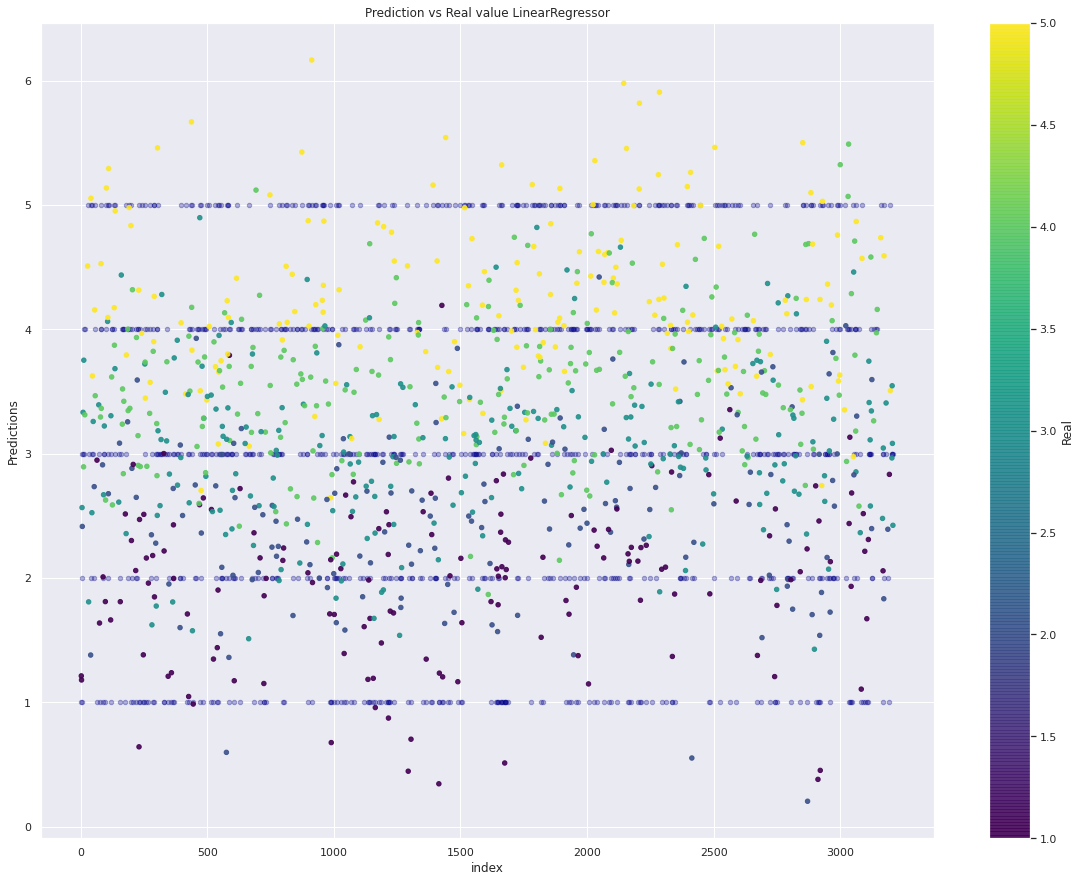

In [48]:
hyperparameters ={
    }
LinearRegressor, results = train_model(LinearRegression, hyperparameters, X_train, y_train, X_test, y_test, results,model_name="LinearRegressor")

### Linear SVM

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best hyperparameters for LinearSVM:
 {'random_state': 42, 'max_iter': 100000, 'epsilon': 0.8, 'C': 25}
Using best parameters, CV MAE score: -0.72
--------------------------------------------------
Test score R2: 0.56
Test score MAE: 0.73


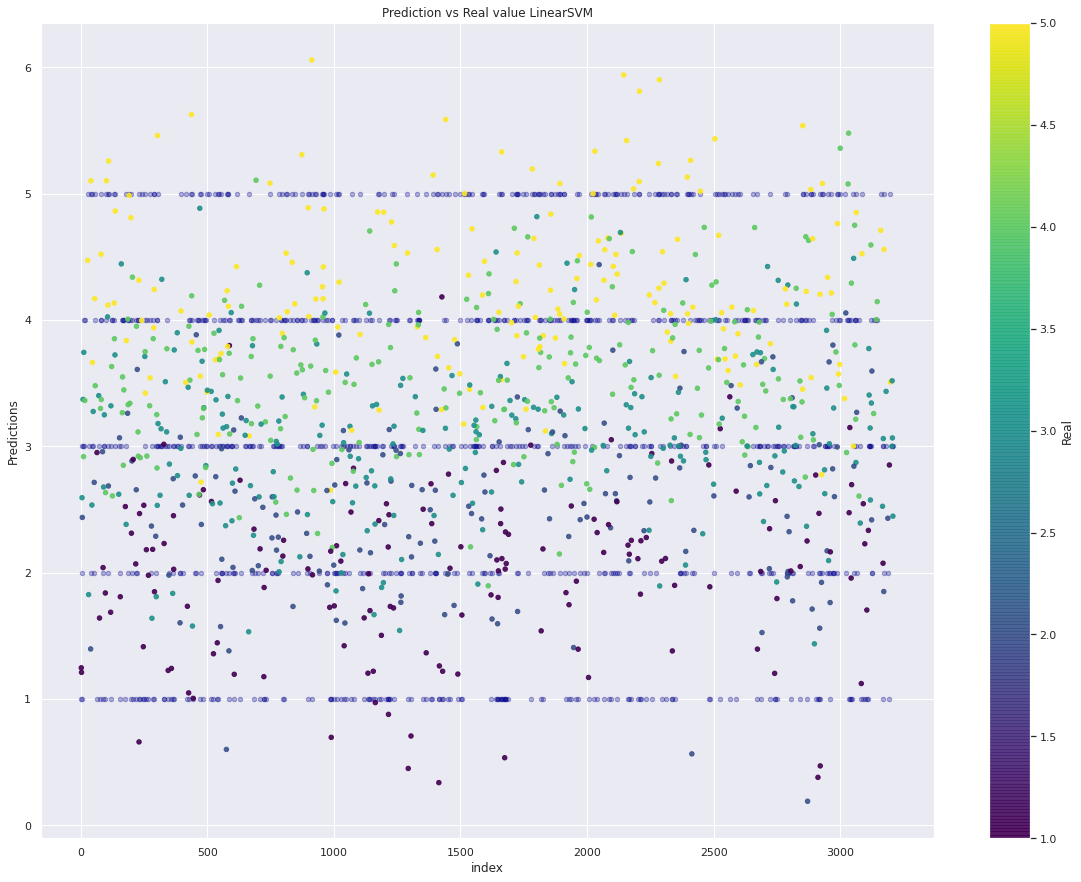

In [49]:
#Parameters searched in local
"""
hyperparameters ={
    'C': [10,25,50,75,100,200,300,400,500,600], 
    'epsilon': [0., 0.2, 0.8, 0.5, 0.1,0.01,0.001,0.0001], 
    'random_state':[42],
    'max_iter':[100000]
    }
"""
#Best parameters found
hyperparameters = {'random_state': [42], 'max_iter': [100000], 'epsilon': [0.8], 'C': [25]}
LinearSVM, results = train_model(LinearSVR, hyperparameters, X_train, y_train, X_test, y_test, results,model_name="LinearSVM")

### Quadratic SVM

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best hyperparameters for QuadraticSVM:
 {'kernel': 'poly', 'epsilon': 1e-05, 'degree': 2, 'coef0': 50, 'C': 1}
Using best parameters, CV MAE score: -0.70
--------------------------------------------------
Test score R2: 0.58
Test score MAE: 0.69


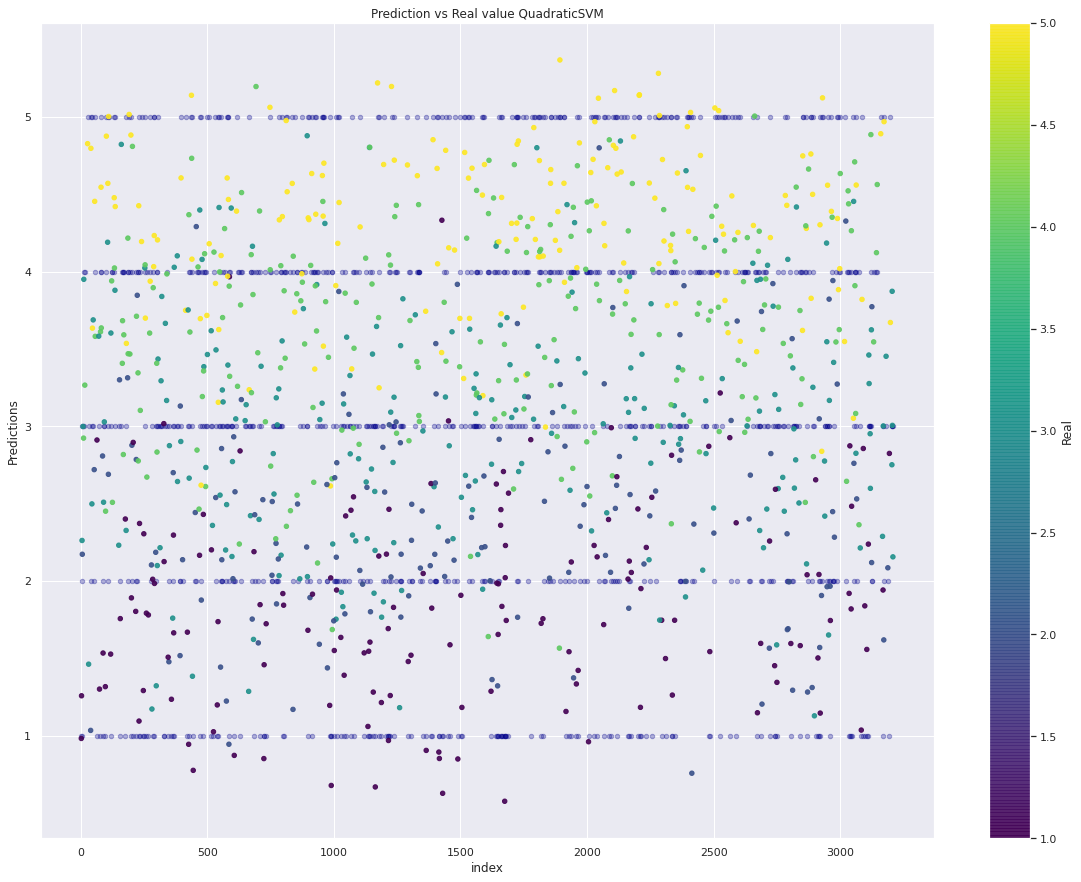

In [50]:
#Parameters searched in local
"""
hyperparameters ={
    "kernel":["poly"],
    "degree":[2],
    'C': [1,2,5,8,10,25,50,75,100], 
    'epsilon': [0,0.1,0.01,0.001,0.0001,0.00001,0.000001],
    'coef0':[10,20,30,40,50] 
    }
"""
#Best parameters found
hyperparameters = {'kernel': ['poly'], 'epsilon': [1e-05], 'degree': [2], 'coef0': [50], 'C': [1]}
QuadraticSVM, results = train_model(SVR, hyperparameters, X_train, y_train, X_test, y_test, results,model_name="QuadraticSVM")

### RBF SVM

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best hyperparameters for rbf_SVM:
 {'kernel': 'rbf', 'gamma': 0.001, 'epsilon': 0.0001, 'C': 1000}
Using best parameters, CV MAE score: -0.69
--------------------------------------------------
Test score R2: 0.59
Test score MAE: 0.68


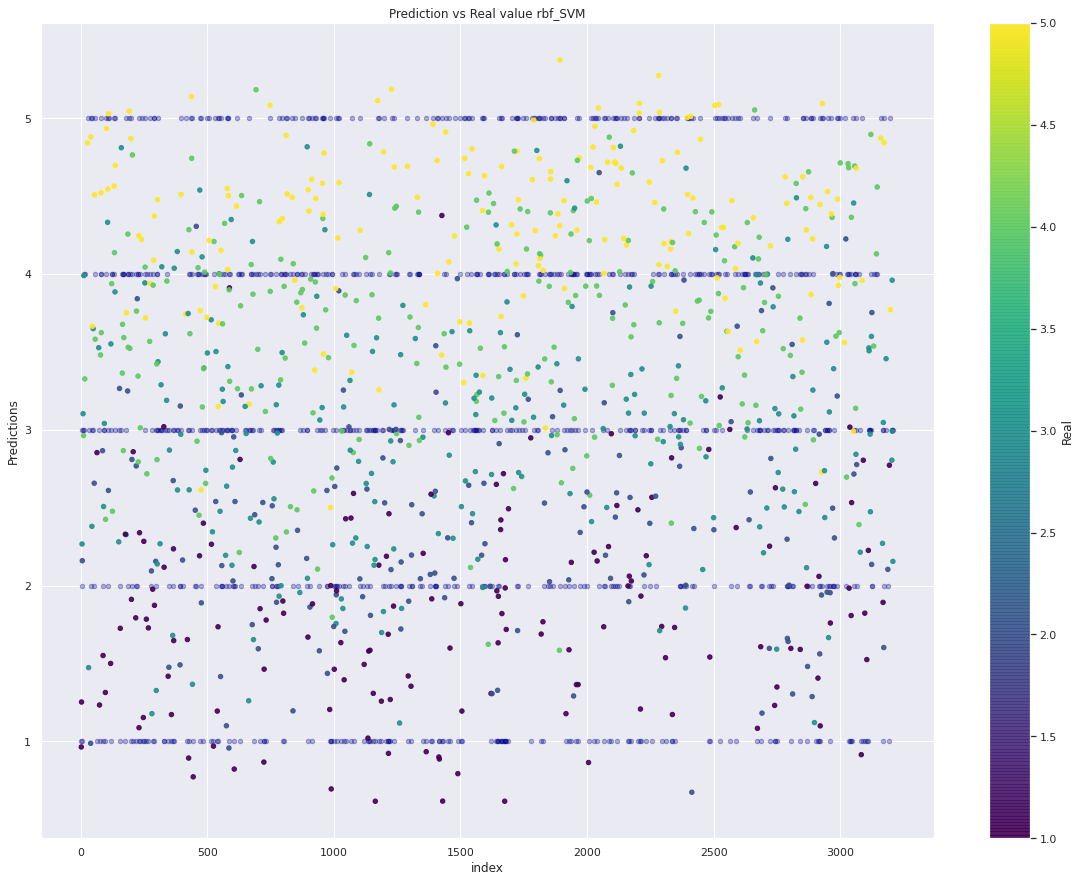

In [51]:
#Parameters searched in local
"""
hyperparameters ={
    "kernel":["rbf"],
    "gamma": [0.5, 0.2, 0.1, 1e-2, 1e-3, 1e-4],
    'C': [10,50,100,150,200,500,750,1000,1500,1750], 
    'epsilon': [1.2, 0.8, 0.5, 0.1,0.01,0.001,0.0001] 
    }
"""
#Best parameters found
hyperparameters = {'kernel': ['rbf'], 'gamma': [0.001], 'epsilon': [0.0001], 'C': [1000]}
rbf_SVM, results = train_model(SVR, hyperparameters, X_train, y_train, X_test, y_test, results,model_name="rbf_SVM")

### Random Forest

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best hyperparameters for RandomForestRegressor:
 {'random_state': 44, 'n_estimators': 225, 'max_features': 'log2', 'max_depth': 23}
Using best parameters, CV MAE score: -0.71
--------------------------------------------------
Test score R2: 0.58
Test score MAE: 0.70


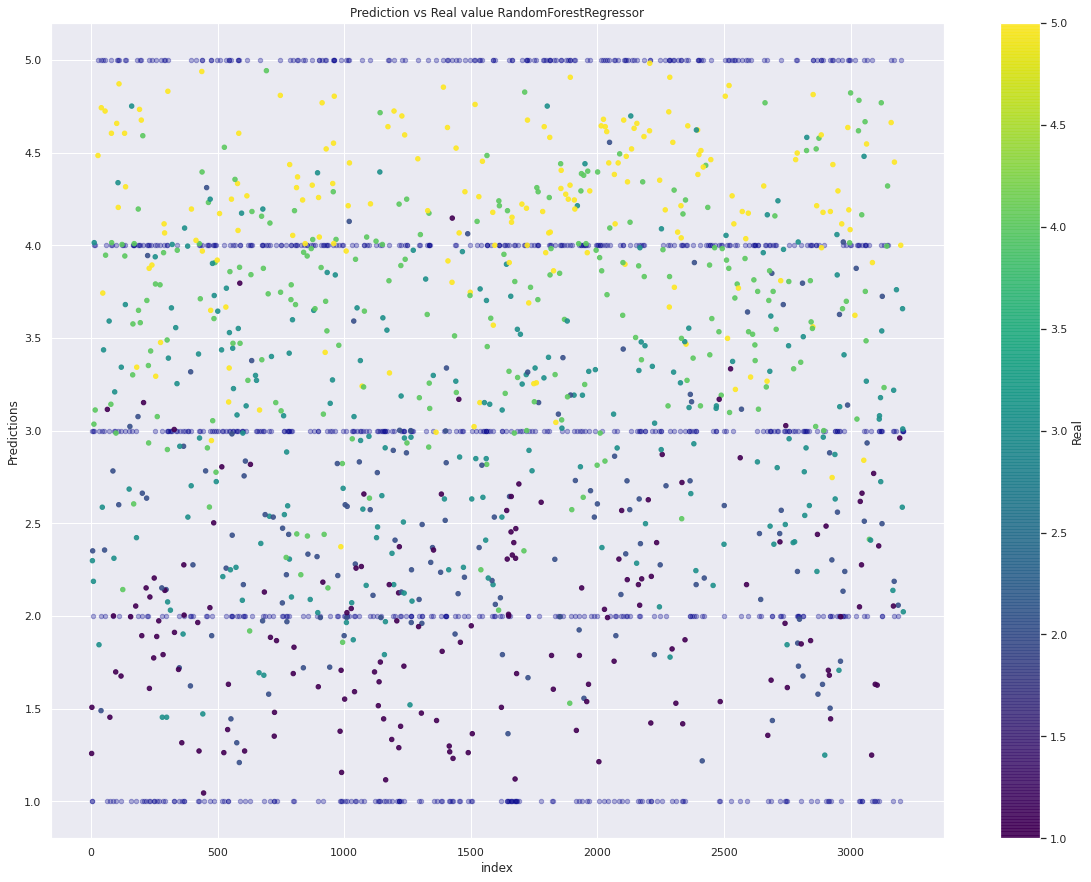

In [52]:
#Parameters searched in local
"""
hyperparameters = {
    'max_depth': np.arange(1,33),
    'max_features': ['sqrt','auto','log2',0.2,0.5],
    'n_estimators': [20,40,60,100,150,200,225,250,275,300], 
    'random_state': [44]
    }
"""
#Best parameters found
hyperparameters = {'random_state': [44], 'n_estimators': [225], 'max_features': ['log2'], 'max_depth': [23]}
RandomForest, results = train_model(RandomForestRegressor, hyperparameters, X_train, y_train, X_test, y_test, results,pca_components=0.90)

## Final Results

In [53]:
(results.T).sort_values("Test score R2",ascending=False)

,Test score R2,Test score MAE,Train score MAE,Prediction Time
rbf_SVM,0.587767,0.682977,-0.692864,1.344426
QuadraticSVM,0.582313,0.689182,-0.698299,0.577963
RandomForestRegressor,0.579276,0.702062,-0.709131,0.547789
LinearRegressor,0.559078,0.725275,-0.724747,0.002178
LinearSVM,0.558238,0.725961,-0.724471,0.000862


Analyzing the final results, one can see that the SVM with RBF kernel produces the best score with the least absolute mean error. Although it offers the best results, by a low margin compared to the others, it also has the greatest prediction time which wouldn't be desirable in real-time applications given that one can get similar results with simpler models.

As a final model, and following the Ockham's Razor principle, we are inclined to pick the simplest model which is the `Linear_Regression` as it has an acceptable prediction score and is the fastest model regarding prediction time.



## Self-Assesment and Conclusions

Looking back at the overall performance obtained with the models, the poor performance could be explained simply because the motor abilities of the players can't fully predict their corresponding rank in the league. But before arriving to such conclusions further studies could be performed, such as:
- Instead of performing Feature Selection one could analyze the performance doing Feature Extraction.
- Choosing different models like K-Nearest Neighbours or a Neural Network.
- Using the models provided by the libraries [mord](https://pythonhosted.org/mord/) or [statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/ordinal_regression.html) which allow Ordinal Regression in Python.
- Instead of training models with all the categories at once, training the models by pairing ranks may increase the separability between categories  (As seen in the original [paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0075129) of the dataset) and by doing so arrive to our own conclusions.

All in all, this project provided an enlightening experience by looking at extracted data from such a popular game as Starcraft 2 and see the different characteristics of the game that could be analyzed and experience first-hand the problems that one can encounter with data in the 'wild'.